# Film Industry Exploratory Data Analysis

## Context
To help a new film studio navigate the competitive movie industry, we are charged with exploring what types of films are currently doing the best at the box office. We must then translate those findings into actionable insights that the head of your company's new movie studio can use to help decide what type of films to create.

This includes examining ratings, budgets (production and marketing), genres, persons (directors & actors attatched to the film) and the audiences preferences. By understanding what is successful, the studio can make informed decisions about the types to develop, ensuring they alight with market demands and maximize profitability.

The buisness questions I seek to answer in this analysis are:
1. Does the combination of genres affect the profitability of the film?
2. Does Release Date Influence Opening Weekend Box Office Success and to what significance?
3. Does the number of films done by a director affect the profitability of the film?
4. Does Production budget have an effect on how profitable a combination of genres will be?
5. Does average rating affect how profitable a film will be?

For all the tests done i'll be adopting a **significance value (alpha) or 0.05**

## Data
I'll be using two datasets and one database;
1. im.db from the International Movies Data Base website (link: https://www.imdb.com/)
2. tn.movie_budgets.csv.gz from The Numbers website (link: https://www.the-numbers.com/)
3. bom.movie_gross.csv.gz from Box Office Mojo website (link: https://www.boxofficemojo.com/)


In [2247]:
# Loading relevant libraries and modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3


In [2248]:
# Loading the data and databases
box_mojo_df = pd.read_csv('bom.movie_gross.csv.gz')
the_numbers_df = pd.read_csv('tn.movie_budgets.csv.gz')
imdb_conn = sqlite3.connect('im.db') # Creates a connection to the database
cursor = imdb_conn.cursor() #create cursor

## Look at the Columns and Details of The Data

In [2250]:
# A quick peek at the database schema
# Define the queries and their corresponding table names
queries = [
    ("This is the persons table contents", "SELECT * FROM persons LIMIT 10;"),
    ("This is the movie ratings table contents", "SELECT * FROM movie_ratings LIMIT 10;"),
    ("This is the movie basics table contents", "SELECT * FROM movie_basics LIMIT 10;"),
    ("This is the movie akas table contents", "SELECT * FROM movie_akas LIMIT 10;"),
    ("This is the principals table contents", "SELECT * FROM principals LIMIT 10;")]

# Execute the queries and print the results
for message, query in queries:
    print(message)
    cursor.execute(query)
    rows = cursor.fetchall()
    print(rows)

This is the persons table contents
[('nm0061671', 'Mary Ellen Bauder', None, None, 'miscellaneous,production_manager,producer'), ('nm0061865', 'Joseph Bauer', None, None, 'composer,music_department,sound_department'), ('nm0062070', 'Bruce Baum', None, None, 'miscellaneous,actor,writer'), ('nm0062195', 'Axel Baumann', None, None, 'camera_department,cinematographer,art_department'), ('nm0062798', 'Pete Baxter', None, None, 'production_designer,art_department,set_decorator'), ('nm0062879', 'Ruel S. Bayani', None, None, 'director,production_manager,miscellaneous'), ('nm0063198', 'Bayou', None, None, 'actor'), ('nm0063432', 'Stevie Be-Zet', None, None, 'composer,soundtrack'), ('nm0063618', 'Jeff Beal', 1963.0, None, 'composer,music_department,soundtrack'), ('nm0063750', 'Lindsay Beamish', None, None, 'actress,miscellaneous')]
This is the movie ratings table contents
[('tt10356526', 8.3, 31), ('tt10384606', 8.9, 559), ('tt1042974', 6.4, 20), ('tt1043726', 4.2, 50352), ('tt1060240', 6.5, 21),

In [2251]:
box_mojo_df.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [2252]:
the_numbers_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [2253]:
the_numbers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [2254]:
box_mojo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


# Data Preparation

### 1. Clean The Box Mojo Data
The foreign gross from the box_mojo dataset is missing over 1000 values. To mitigate this we'll drop the column and use the_numbers_df dataset to create a column with just the foreign gross as worldwide gross is a sum of foreign and domestic as implied in thier website glossary (https://www.the-numbers.com/glossary).

In [2257]:
box_mojo_df.isnull().sum()

title                0
studio               5
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64

In [2258]:
box_mojo_df = box_mojo_df.drop('foreign_gross', axis=1)

### 2. Clean The Numbers Data

In [2260]:
# Remove the dollar sign,$ and the commas ',' from the columns and turn them into numeric values

the_numbers_df['production_budget'] = pd.to_numeric(the_numbers_df['production_budget'].replace({'\$': '', ',': ''}, regex=True))
the_numbers_df['domestic_gross'] = pd.to_numeric(the_numbers_df['domestic_gross'].replace({'\$': '', ',': ''}, regex=True))
the_numbers_df['worldwide_gross'] = pd.to_numeric(the_numbers_df['worldwide_gross'].replace({'\$': '', ',': ''}, regex=True))


In [2261]:
# Create a foreign_gross column using the values of worldwide and domestic gross
the_numbers_df['foreign_gross'] = the_numbers_df['worldwide_gross'] - the_numbers_df['domestic_gross']

In [2262]:
# Convert release_date column into a datetime object and create a year column and a profit column
the_numbers_df['release_date'] = pd.to_datetime(the_numbers_df['release_date'], format='%b %d, %Y')
the_numbers_df['year'] = the_numbers_df['release_date'].dt.year
the_numbers_df.loc[:, 'profit'] = the_numbers_df['worldwide_gross'] - the_numbers_df['production_budget']
the_numbers_df = the_numbers_df.sort_values(by='profit', ascending=False)
the_numbers_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5782 entries, 0 to 2
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   movie              5782 non-null   object        
 3   production_budget  5782 non-null   int64         
 4   domestic_gross     5782 non-null   int64         
 5   worldwide_gross    5782 non-null   int64         
 6   foreign_gross      5782 non-null   int64         
 7   year               5782 non-null   int32         
 8   profit             5782 non-null   int64         
dtypes: datetime64[ns](1), int32(1), int64(6), object(1)
memory usage: 429.1+ KB


In [2263]:
# Check for Duplicates and Drop them
the_numbers_df = the_numbers_df.drop_duplicates(subset=['movie'], keep='last')
box_mojo_df.dropna()
box_mojo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 106.0+ KB


## Use the imdb Database to select relevant information into a dataframe and Clean the data as imdb_df

I'll use the im.db database to create a dataframe with genre, director, movie title, region, averagerating and number of votes.

In [2265]:
#Select the primary title(movie title), genres, primary_name(director) and the average rating form the database
#Turn the selected information into a dataframe and close the connection to the database
imdb_query = """
SELECT
    mb.primary_title, 
    mb.genres,
    p.primary_name,
    mr.averagerating
FROM movie_basics AS mb
JOIN directors AS d
    ON mb.movie_id = d.movie_id
JOIN persons AS p
    ON d.person_id = p.person_id
JOIN movie_akas AS ma
    ON mb.movie_id = ma.movie_id
JOIN movie_ratings as mr
    ON mr.movie_id = mb.movie_id
WHERE p.primary_profession LIKE '%director%';
"""
imdb_df = pd.read_sql(imdb_query, imdb_conn)
imdb_conn.close()
imdb_df.head()

,primary_title,genres,primary_name,averagerating
0,Paano na kaya,"Drama,Romance",Ruel S. Bayani,6.4
1,Paano na kaya,"Drama,Romance",Ruel S. Bayani,6.4
2,Paano na kaya,"Drama,Romance",Ruel S. Bayani,6.4
3,Paano na kaya,"Drama,Romance",Ruel S. Bayani,6.4
4,No Other Woman,"Drama,Romance,Thriller",Ruel S. Bayani,6.4


In [2266]:
# Drop duplicate movie titles
imdb_df = imdb_df.drop_duplicates(subset=['primary_title'], keep='last')
imdb_df.head()

,primary_title,genres,primary_name,averagerating
3,Paano na kaya,"Drama,Romance",Ruel S. Bayani,6.4
6,No Other Woman,"Drama,Romance,Thriller",Ruel S. Bayani,6.4
9,One More Try,Drama,Ruel S. Bayani,5.8
10,Not Such a Bad Guy: Conversations with Dabney ...,Documentary,Bryan Beasley,8.9
17,The Cursed,"Horror,Romance,Thriller",Joel Bender,5.9


In [2267]:
# Check for Null values and drop them
imdb_df.info()
imdb_df.dropna()

<class 'pandas.core.frame.DataFrame'>
Index: 61478 entries, 3 to 663468
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   primary_title  61478 non-null  object 
 1   genres         60932 non-null  object 
 2   primary_name   61478 non-null  object 
 3   averagerating  61478 non-null  float64
dtypes: float64(1), object(3)
memory usage: 2.3+ MB


,primary_title,genres,primary_name,averagerating
3,Paano na kaya,"Drama,Romance",Ruel S. Bayani,6.4
6,No Other Woman,"Drama,Romance,Thriller",Ruel S. Bayani,6.4
9,One More Try,Drama,Ruel S. Bayani,5.8
10,Not Such a Bad Guy: Conversations with Dabney ...,Documentary,Bryan Beasley,8.9
17,The Cursed,"Horror,Romance,Thriller",Joel Bender,5.9
...,...,...,...,...
663453,Porisadaya,"Action,Crime,Drama",Sirithunga Perera,7.7
663456,The Jack King Affair,Documentary,Nicolas Cotto,6.4
663459,Shaghaltna Arjantenia,Comedy,Hamed Saleh,6.5
663465,Late Life: The Chien-Ming Wang Story,"Documentary,Sport",Frank W Chen,5.8


### Rename the Primary key into movie_title and Merge the datasets

In [2269]:
# Rename the movie title columns to movie_title which we'll use as the primary key
imdb_df = imdb_df.rename(columns={'primary_title': 'movie_title'})
the_numbers_df = the_numbers_df.rename(columns={'movie': 'movie_title'})
box_mojo_df = box_mojo_df.rename(columns={'title': 'movie_title'})

#### The data we merge from numbers and box mojo contain the most accurate representation of our population data using our dependant variable, thus the result **movie_data** will be used as our population data later on

In [2271]:
# First merge the numbers and box mojo dataframes. 
# This will be used for to test if the distribution matches with our final dataset

movie_data = pd.merge(box_mojo_df, the_numbers_df, on=['movie_title'], how='inner')
movie_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1238 entries, 0 to 1237
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   movie_title        1238 non-null   object        
 1   studio             1237 non-null   object        
 2   domestic_gross_x   1236 non-null   float64       
 3   year_x             1238 non-null   int64         
 4   id                 1238 non-null   int64         
 5   release_date       1238 non-null   datetime64[ns]
 6   production_budget  1238 non-null   int64         
 7   domestic_gross_y   1238 non-null   int64         
 8   worldwide_gross    1238 non-null   int64         
 9   foreign_gross      1238 non-null   int64         
 10  year_y             1238 non-null   int32         
 11  profit             1238 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(7), object(2)
memory usage: 111.4+ KB


In [2272]:
# Then finally merge with our imdb dataframe

final_movie_df = pd.merge(movie_data, imdb_df, on=['movie_title'], how='inner')
final_movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1077 entries, 0 to 1076
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   movie_title        1077 non-null   object        
 1   studio             1077 non-null   object        
 2   domestic_gross_x   1076 non-null   float64       
 3   year_x             1077 non-null   int64         
 4   id                 1077 non-null   int64         
 5   release_date       1077 non-null   datetime64[ns]
 6   production_budget  1077 non-null   int64         
 7   domestic_gross_y   1077 non-null   int64         
 8   worldwide_gross    1077 non-null   int64         
 9   foreign_gross      1077 non-null   int64         
 10  year_y             1077 non-null   int32         
 11  profit             1077 non-null   int64         
 12  genres             1073 non-null   object        
 13  primary_name       1077 non-null   object        
 14  averager

In [2273]:
# Rename Columns
final_movie_df = final_movie_df.rename(columns={'year_y': 'year', 'profit': 'gross_profit', 'primary_name': 'director'})
# Create columns representing the month and day or release
final_movie_df['release_month'] = final_movie_df['release_date'].dt.strftime('%b')
final_movie_df['release_day'] = final_movie_df['release_date'].dt.strftime('%d')
# Drop irrelevant columns
final_movie_df = final_movie_df.drop(columns=['id', 'release_date','domestic_gross_x', 'year_x', 'domestic_gross_y','worldwide_gross','foreign_gross'])
final_movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1077 entries, 0 to 1076
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie_title        1077 non-null   object 
 1   studio             1077 non-null   object 
 2   production_budget  1077 non-null   int64  
 3   year               1077 non-null   int32  
 4   gross_profit       1077 non-null   int64  
 5   genres             1073 non-null   object 
 6   director           1077 non-null   object 
 7   averagerating      1077 non-null   float64
 8   release_month      1077 non-null   object 
 9   release_day        1077 non-null   object 
dtypes: float64(1), int32(1), int64(2), object(6)
memory usage: 80.1+ KB


In [2274]:
final_movie_df.describe()

,production_budget,year,gross_profit,averagerating
count,1.077000e+03,1077.000000,1.077000e+03,1077.000000
mean,4.829740e+07,2013.505107,1.108624e+08,6.450139
std,5.656255e+07,3.344699,2.024068e+08,0.993020
min,1.000000e+05,1967.000000,-1.104502e+08,1.600000
25%,1.100000e+07,2011.000000,2.837111e+06,5.900000
50%,2.800000e+07,2014.000000,3.410859e+07,6.500000
75%,6.000000e+07,2016.000000,1.224983e+08,7.100000
max,4.106000e+08,2018.000000,1.748134e+09,9.200000


## Statistical Analysis of the Variable 

**Gross profit** being our dependant variable y, we'll check how it represents the population data we just cleaned i.e Wether it's a linear or a non-linear distribution.

### Check the normality of our data using a histogram

C:\Users\ADMIN\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Histogram of Gross Profit')

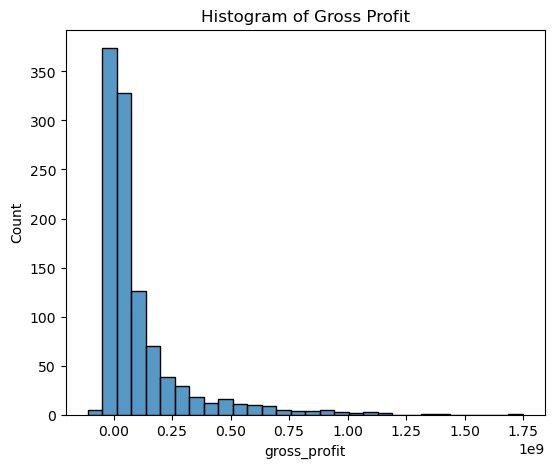

In [2278]:
# Histogram
plt.figure(figsize=(21, 5))
plt.subplot(1, 3, 1)
sns.histplot(final_movie_df['gross_profit'], bins=30, kde=False)
plt.title('Histogram of Gross Profit')


## Initial Exploratory Analysis

### Genre
We can use probability mass function to measure the likelyhood a genre is profitable by using the final_movie_df. The number of outcomes is finite and the outcome is a set of values.

In [2281]:
genre_counts = final_movie_df['genres'].value_counts()
genre_counts

genres
Drama                         52
Adventure,Animation,Comedy    47
Action,Adventure,Sci-Fi       39
Comedy,Drama,Romance          38
Comedy,Drama                  35
                              ..
Comedy,Drama,Sport             1
Action,Family,Fantasy          1
Comedy,Horror,Romance          1
Drama,Mystery                  1
Adventure,Drama                1
Name: count, Length: 200, dtype: int64

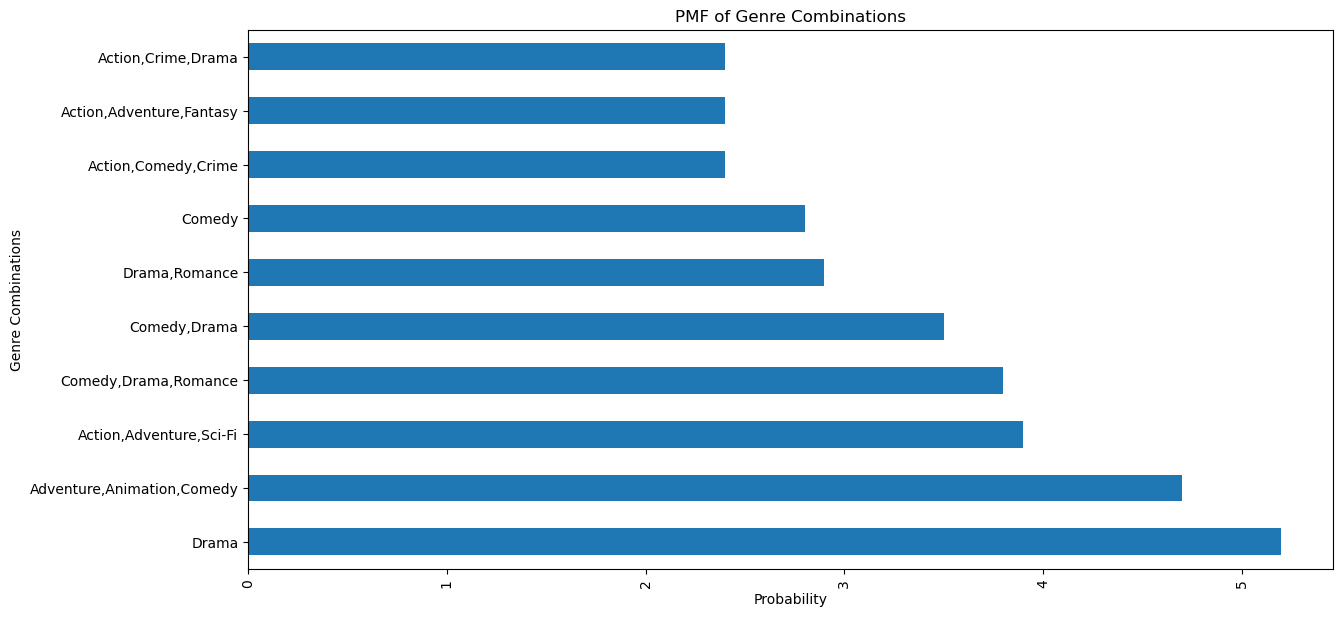

In [2282]:
genre_counts = genre_counts.head(10)
pmf = genre_counts /10

plt.figure(figsize=(14, 7))
pmf.plot(kind='barh')
plt.title('PMF of Genre Combinations')
plt.ylabel('Genre Combinations')
plt.xlabel('Probability')
plt.xticks(rotation=90)
plt.show()

A combination of **Action, Adventure and Comedy** has the highest probability of being profitable

## Use Statistical Test To Check The Significance Of Our Cleaned Data

## The Three Buisness Questions

Returning to the three buisness questions we needed answered i.e

1. What Genres Are Most Profitable?
2. Does Release Date Influence Opening Weekend Box Office Success?
3. Which the directors have the highest success rate?



### What Genres Are Most Profitable? 

From the visualisation below we can see combination of either action or adventure or both genres have the highest gross profit. When elements of Drama, Comedy or science fiction are added to this combination it increases the chances of making greater margins. So if there were to be three combinations our film buisness should invest in it would be:
- **Action, Drama, Adventure**
- **Adventure, Sci-Fi, Action**
- **Adventure, Comedy, Action**

Documentary, Biography, History and Sport are not replicable since content itself may not be copyrighted (facts and historical events are in the public domain thus are not considered original video content in this context.

In [2287]:
profit_genres_mean = final_movie_df[['genres','gross_profit']].groupby(['genres']).agg(['count','mean', 'median'])
profit_genres_mean.sort_values(by=('gross_profit','count'), ascending=False).head(20)

gross_profit                           
                                  count          mean       median
genres                                                            
Drama                                52  3.924794e+07   13125820.0
Adventure,Animation,Comedy           47  2.917868e+08  166562312.0
Action,Adventure,Sci-Fi              39  5.397891e+08  488986787.0
Comedy,Drama,Romance                 38  3.210311e+07    6998217.5
Comedy,Drama                         35  3.643023e+07   16773510.0
Drama,Romance                        29  4.656964e+07   22004627.0
Comedy                               28  5.406900e+07   28418755.5
Action,Comedy,Crime                  24  6.995661e+07   67536796.0
Action,Crime,Drama                   24  4.180626e+07   30454672.5
Action,Adventure,Fantasy             24  2.666522e+08  169373792.0
Comedy,Romance                       23  8.105173e+07   59553797.0
Documentary                          20  6.596635e+07   18267266.0
Horror,Mystery,Thriller              20  1.062433e+08   76826435.5
Action,Adventure,Drama               19  1.144388e+08   70497035.0
Drama,Thriller                       18  4.887243e+07   14766234.5
Action,Adventure,Comedy              17  3.330677e+08  304803696.0
Biography,Drama,History              17  7.820956e+07   47586407.0
Crime,Drama,Thriller                 16  1.906243e+07   25516773.0
Action,Crime,Thriller                16  2.076518e+08   36229119.0
Biography,Comedy,Drama               16  4.428798e+07   20389073.5

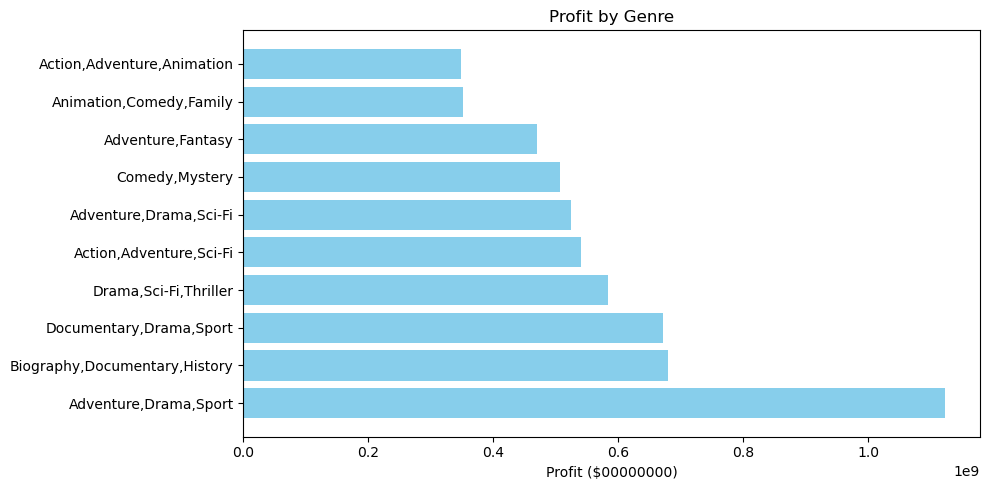

In [2368]:
# Visulaise the average profit per genre combination
genre_profit = final_movie_df.groupby('genres')['gross_profit'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,5))
bars = plt.barh(genre_profit.index, genre_profit.values, color='skyblue')
plt.xlabel('Profit ($00000000)')
plt.title('Profit by Genre')
plt.tight_layout()
plt.show()

### Does Release Date Influence Opening Weekend Box Office Success?
Studios release movies  based on particular holidays and months in order to target the overall sentiments. This means some months have higher revenue generation than other months. The visualisation below illustrates five months that have high profits, namely:
- **May**
- **June**
- **July**
- **November**
- **December**

It would be advisable to the buisness to consider timing it's releases around these months for better returns.

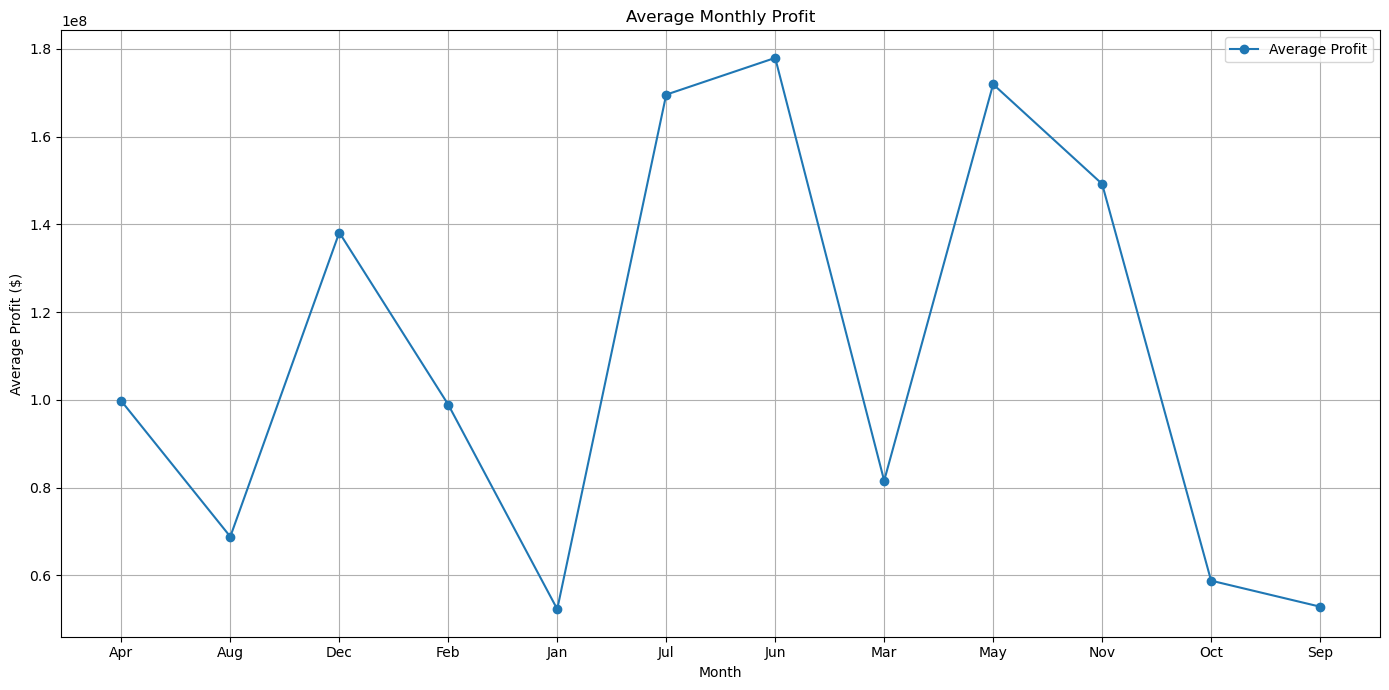

In [2290]:
average_profit_per_month = final_movie_df.groupby('release_month')['gross_profit'].mean()

# Plotting the average profit per month
plt.figure(figsize=(14, 7))
plt.plot(average_profit_per_month.index, average_profit_per_month.values, label='Average Profit', marker='o', linestyle='-')
plt.xlabel('Month')
plt.ylabel('Average Profit ($)')
plt.title('Average Monthly Profit')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

To specify the release day's of the month with most gross profit, below is an additional visualization for this variable. The most successful realease day is usually on the **3rd of the month** as shown below.

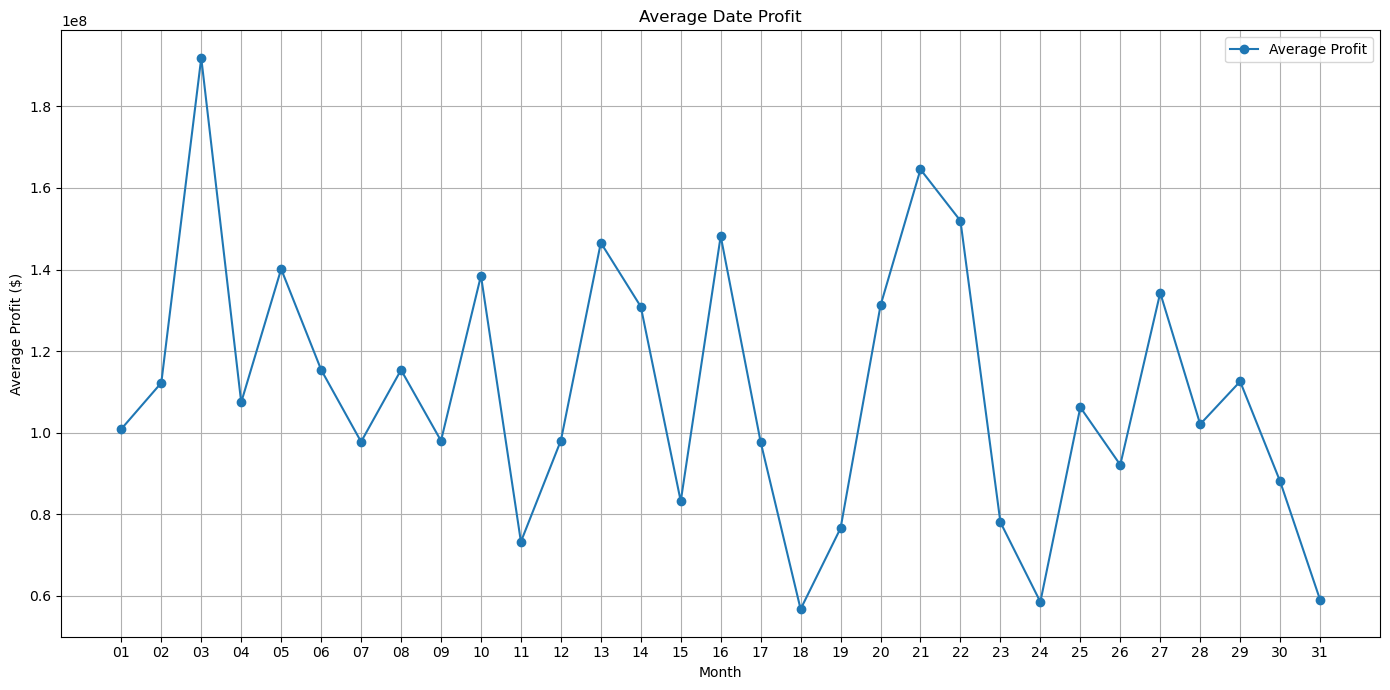

In [2292]:
average_profit_per_date = final_movie_df.groupby('release_day')['gross_profit'].mean()

# Plotting the average profit per month
plt.figure(figsize=(14, 7))
plt.plot(average_profit_per_date.index, average_profit_per_date.values, label='Average Profit', marker='o', linestyle='-')
plt.xlabel('Month')
plt.ylabel('Average Profit ($)')
plt.title('Average Date Profit')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Which directors have the highest success rate?
Based on experience and mean gross profit in the visualisation below the top five directors the new buisness stakeholders can trust with a big budget film are:
- **Steven Spielberg**
- **Clint Eastwood**
- **Francis Lawrence**
- **Jon M. Chu**
- **Tim Story**

These directors have consistent profitability in the projects they undertake despite not having the highest grossing films of all time.

In [2294]:
# Creates the dataset grouped by directors and displays their average gross profit for the total films they've directed
profit_directors_mean = final_movie_df[['director','gross_profit']].groupby(['director']).agg(['count','mean', 'median'])
profit_directors_mean.sort_values(by=('gross_profit','count'), ascending=False).head(20)

gross_profit                           
                          count          mean       median
director                                                  
Steven Spielberg              7  1.829057e+08  129748880.0
Clint Eastwood                6  1.379160e+08   54133150.0
Francis Lawrence              5  4.042383e+08  488986787.0
Jon M. Chu                    5  1.531137e+08  208099711.0
Tim Story                     5  7.815801e+07   84827316.0
Ridley Scott                  5  2.281130e+08  141521247.0
Jaume Collet-Serra            5  7.134972e+07   61985431.0
Zack Snyder                   5  2.941840e+08  355945209.0
Steven Soderbergh             5  5.649705e+07   15264271.0
Pierre Coffin                 4  8.549363e+08  929472292.5
James Wan                     4  6.779971e+08  642447390.5
Antoine Fuqua                 4  1.045980e+08  108166030.0
Christopher Nolan             4  5.840451e+08  588452008.5
Robert Zemeckis               4  3.429803e+07   19879382.5
Joe Wright                    4  4.492037e+07   28674160.5
Mike Mitchell                 4  3.291241e+08  253050852.0
Bryan Singer                  4  4.387683e+08  456200160.5
Jeff Nichols                  4  3.839322e+06    2060040.0
Paul W.S. Anderson            4  1.791480e+08  207010909.5
Denis Villeneuve              4  8.807034e+07   70879855.0

In [2295]:
# Creates the dataset grouped by genres and displays their average production budget for the total films they've produced
profit_genres_mean = final_movie_df[['genres', 'production_budget']].groupby(['genres']).agg(['count', 'mean', 'median'])
profit_genres_mean.sort_values(by=('production_budget', 'count'), ascending=False).head(20)


production_budget                           
                                       count          mean       median
genres                                                                 
Drama                                     52  1.936731e+07   12750000.0
Adventure,Animation,Comedy                47  9.712766e+07   80000000.0
Action,Adventure,Sci-Fi                   39  1.673487e+08  175000000.0
Comedy,Drama,Romance                      38  1.624474e+07    9000000.0
Comedy,Drama                              35  1.924343e+07   17000000.0
Drama,Romance                             29  1.836724e+07   16000000.0
Comedy                                    28  3.374643e+07   27500000.0
Action,Comedy,Crime                       24  4.291667e+07   39000000.0
Action,Crime,Drama                        24  2.871667e+07   30000000.0
Action,Adventure,Fantasy                  24  1.556500e+08  150000000.0
Comedy,Romance                            23  2.809130e+07   24000000.0
Documentary                               20  4.040000e+07   20000000.0
Horror,Mystery,Thriller                   20  8.005000e+06    6250000.0
Action,Adventure,Drama                    19  9.942105e+07  110000000.0
Drama,Thriller                            18  2.300833e+07   14500000.0
Action,Adventure,Comedy                   17  1.027647e+08  104000000.0
Biography,Drama,History                   17  2.505882e+07   25000000.0
Crime,Drama,Thriller                      16  2.121875e+07   21000000.0
Action,Crime,Thriller                     16  7.212500e+07   55000000.0
Biography,Comedy,Drama                    16  1.925000e+07   17500000.0

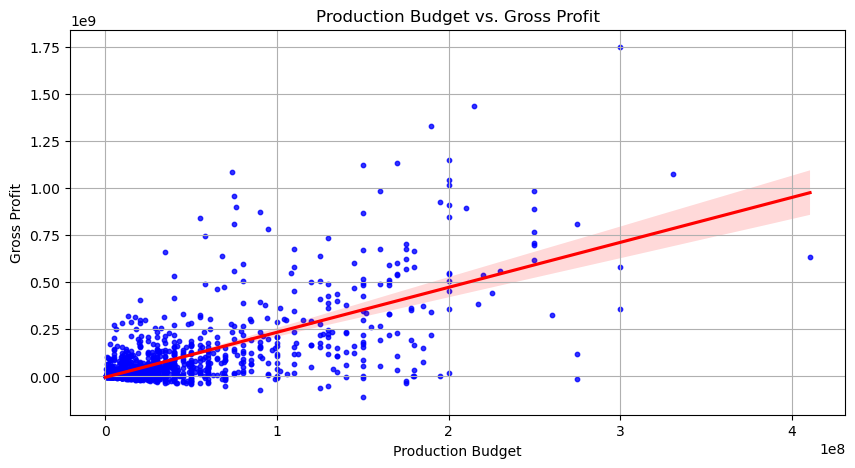

In [2372]:
# Scatter plot with a regression line to visualise the effect size on thr gross profit
plt.figure(figsize=(10, 5))
sns.regplot(x='production_budget', y='gross_profit', data=final_movie_df, scatter_kws={'s':10, 'color':'blue'}, line_kws={"color":"red"})
plt.title('Production Budget vs. Gross Profit')
plt.xlabel('Production Budget')
plt.ylabel('Gross Profit')
plt.grid(True)
plt.show()

In [2297]:
# Creates the dataset grouped by average rating and displays their average gross profit for the total films they've ranked
profit_genres_mean = final_movie_df[['averagerating','gross_profit']].groupby(['averagerating']).agg(['count','mean', 'median'])
profit_genres_mean.sort_values(by=('gross_profit','count'), ascending=False).head(20)

gross_profit                          
                     count          mean      median
averagerating                                       
6.3                     56  1.028522e+08  45055701.5
6.6                     54  1.291332e+08  34500439.5
6.8                     51  7.142417e+07  27000339.0
6.2                     50  1.125849e+08  44618823.5
7.0                     48  1.469819e+08  33525986.0
6.5                     48  1.033555e+08  46096244.5
6.4                     46  5.900833e+07  21366985.0
7.2                     44  1.332261e+08  22954369.0
6.7                     42  9.288485e+07  40210703.0
7.3                     38  1.508347e+08  36924341.5
7.1                     38  1.159145e+08  40695658.0
5.7                     35  8.260822e+07  31158601.0
6.9                     35  9.027258e+07  18073377.0
5.8                     31  5.252623e+07  13374700.0
6.1                     31  4.864317e+07  14811293.0
5.9                     30  3.850675e+07  21828452.5
6.0                     29  1.101556e+08  72678948.0
7.4                     28  1.413950e+08  25366817.0
7.6                     26  1.294557e+08  65415984.5
7.5                     24  2.044020e+08  78989930.0

## Hypothesis Testing
Before we determine whether to reject or accept the Null Hypothesis
The steps we'll be taking are as follows:
1. Check if the final_data_df (sample) represents our population_data (**movie_data**). We are using the numbers data since it contains the merged value of both the box and numbers data as well as the largest column of our dependant variable **profit**
2. Normalise our data if askew using IQR
3. Perfom tests based on the results of the above steps

### Check if the Distribution of our data represents the movie_data
Kolmogorov-Smirnov test to check if the datasets follow the same distribution.
The large p value of 0.999 suggests that the final_movie_df represents the movie_data and they have the same distributions

In [2300]:
# Use the Kolmogorov-Smirnov Test to check if final_movie_df corresponds with the_numbers_df

from scipy.stats import ks_2samp # import the stats module for K-S test

statistic, p_value = ks_2samp(movie_data['profit'], final_movie_df['gross_profit'])
print(f"K-S Statistic: {statistic}, P-Value: {p_value}")


K-S Statistic: 0.015149333321333266, P-Value: 0.9990727811060789


### Perform a IQR to reduce Outliers

In [2302]:
Q1 = final_movie_df['gross_profit'].quantile(0.25)
Q3 = final_movie_df['gross_profit'].quantile(0.75)
IQR = Q3 - Q1
unskewd_df = final_movie_df[(final_movie_df['gross_profit'] >= (Q1 - 1.5 * IQR)) & (final_movie_df['gross_profit'] <= (Q3 + 1.5 * IQR))]


C:\Users\ADMIN\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Histogram of Gross Profit')

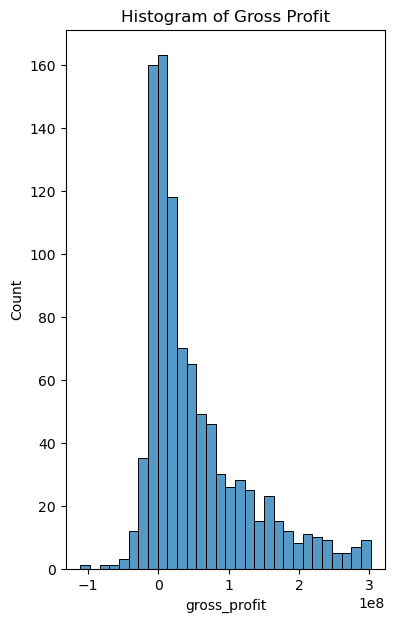

In [2303]:
# Check if the data is normalized with a Histogram
plt.figure(figsize=(14, 7))
plt.subplot(1, 3, 1)
sns.histplot(unskewd_df['gross_profit'], bins=30, kde=False)
plt.title('Histogram of Gross Profit')

The data is somewhat normalised but not enough to do any normal ttests. Due to this well be using the following tests on our Hypotheses;
1. Spearman's Rank Correlation
2. Kruskal-Wallis H test

### Does the combination of genres affect the profitability of the film?

We'll us the Kruskal-Wallis H test for the following reasons;-
1. Its a non-parametric test that compares the medians of three or more independent groups
3. Its suitable for this analysis because profitability data may not be normally distributed, and genre combinations form distinct groups

In [2306]:
from scipy.stats import kruskal

# Group the data by genre combination and collect gross profits
grouped = final_movie_df.groupby('genres')['gross_profit'].apply(list)

# Prepare data for Kruskal-Wallis test & Remove groups with only one sample
data = [profits for profits in grouped if len(profits) > 1]  
# Apply the Kruskal-Wallis H test
statistic, p_value = kruskal(*data)
# print results
print(f"Kruskal-Wallis H Test Statistic: {statistic}, P-Value: {p_value}")

Kruskal-Wallis H Test Statistic: 335.43653114340486, P-Value: 2.232885895020977e-21


The extremely low p-value (much less than 0.05) indicates that we reject the null hypothesis, which poses that the median gross profits are the same across all genre combinations. This result suggests that there are significant differences in gross profit among the different genre combinations in the dataset. In other words, the **genre combination of a film appears to have a substantial impact on its profitability.**

### Does Release Date Influence Opening Weekend Box Office Success?
We saw earlier in our analysis that certain months and dates record the highest profitability for film relesed in those times. We test to see of this observation is significant to our study or not.

In [2309]:
from scipy.stats import spearmanr

spearman_corr, p_value = spearmanr(final_movie_df['release_month'], final_movie_df['gross_profit'])
print(f"Spearman's Rank Correlation: {spearman_corr}, p-value: {p_value}")
spearman_corr, p_value = spearmanr(final_movie_df['release_day'], final_movie_df['gross_profit'])
print(f"Spearman's Rank Correlation: {spearman_corr}, p-value: {p_value}")

Spearman's Rank Correlation: -0.024555484252722592, p-value: 0.42079684871391854
Spearman's Rank Correlation: -0.02247798273751666, p-value: 0.46117606030271985


The correlation coefficients are close to 0, indicating a very weak or negligible correlation between the variables in both cases.
The high p-value indicates that we fail to reject the null hypothesis, which in this context means there is no statistically significant correlation between the release month or release day and the gross profit.

The analysis suggests that **there is no significant relationship between the release month or release day and the profitability of the films in your dataset**. The very weak correlation and high p-values imply that other factors are likely more influential in determining a film's gross profit.

### Does the number of films done by a director affect the profitability of the film?
We would like to test to see if the more films a director does accounts for the more profitable they are.

In [2312]:
director_counts = final_movie_df['director'].value_counts().to_dict()

# Map the number of films directed to each movie
final_movie_df['num_films_directed'] = final_movie_df['director'].map(director_counts)

# Calculate the Spearman's rank correlation
correlation, p_value = spearmanr(final_movie_df['num_films_directed'], final_movie_df['gross_profit'])

print(f"Spearman's correlation: {correlation}, P-value: {p_value}")

Spearman's correlation: 0.30665503901567387, P-value: 6.957852339217805e-25


The positive correlation coefficient of 0.31 indicates a moderate positive relationship between the number of films directed by a director and the gross profit. The very low p-value (much less than 0.05) suggests that this correlation is statistically significant. This means that, generally, **directors who have directed more films tend to be associated with higher gross profits**, indicating that experience in directing may contribute to a film's profitability.

### Does Production Budget affect a films Profitability?

In [2315]:
spearman_corr, p_value = spearmanr(final_movie_df['production_budget'], final_movie_df['gross_profit'])
print(f"Spearman's Rank Correlation: {spearman_corr}, p-value: {p_value}")

Spearman's Rank Correlation: 0.5156891948642754, p-value: 3.1976725391633338e-74


The positive correlation coefficient of 0.52 indicates a strong positive relationship between the production budget and the gross profit of films. The very low p-value (much less than 0.05) suggests that this correlation is statistically significant. This implies that **films with higher production budgets tend to generate higher gross profits**. However, while the correlation is strong, it doesn't necessarily imply causation, as other factors could also contribute to profitability.

### Does average rating affect how profitable a film will be?

In [2318]:
spearman_corr, p_value = spearmanr(final_movie_df['averagerating'], final_movie_df['gross_profit'])
print(f"Spearman's Rank Correlation: {spearman_corr}, p-value: {p_value}")

Spearman's Rank Correlation: 0.1935309293162752, p-value: 1.508604191366108e-10


The correlation coefficient indicates the strength and direction of the relationship between average rating and gross profit. A positive coefficient **suggests that higher average ratings are associated with higher gross profits**, while a negative coefficient indicates an inverse relationship.

# Linear Regression Model

The model will predict the gross_profit using various predictors such as production_budget, average_rating, and others. 
This example will use the sklearn library for simplicity.

In [2322]:
from sklearn.preprocessing import StandardScaler

# Creating a copy of our final data
model_df = final_movie_df.copy()
# One-Hot Encoding for 'genres' and selecting relevant columns
model_df = pd.get_dummies(model_df, columns=['genres'], drop_first=True)
X = model_df[['production_budget', 'averagerating'] + [col for col in model_df.columns if col.startswith('genres_')]]
y = model_df['gross_profit']
# Scaling features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Adding a constant
X_scaled = sm.add_constant(X_scaled)
# Fitting the model
model = sm.OLS(y, X_scaled).fit()
# Displaying the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           gross_profit   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     6.395
Date:                Sun, 28 Jul 2024   Prob (F-statistic):           2.20e-84
Time:                        21:08:37   Log-Likelihood:                -21639.
No. Observations:                1077   AIC:                         4.368e+04
Df Residuals:                     875   BIC:                         4.469e+04
Df Model:                         201                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.109e+08   4.35e+06     25.470      0.0

- **R-squared and Adjusted R-squared**: The R-squared value of 0.595 indicates that the model explains approximately 59.5% of the variance in the gross_profit. The Adjusted R-squared, which adjusts for the number of predictors, is slightly lower at 0.502, **suggesting that some predictors may not contribute significantly to the model**.

- **F-statistic and Prob (F-statistic)**: The F-statistic of 6.395 with a p-value of approximately 2.20 indicates that the overall model is statistically significant, meaning that **at least some of the predictor variables are related to the response variable gross_profit**.

- **Coefficients** : The table of coefficients (coef), standard errors (std err), t-values (t), and p-values (P>|t|) shows the estimated effect of each predictor on gross_profit. A few points to note:

The const term (intercept) has a significant positive coefficient, suggesting a baseline gross profit.
Several predictors have significant coefficients (p-value < 0.05), **indicating that they have a statistically significant impact on gross_profit. For example, x1 (one of the genre categories) has a large positive coefficient, suggesting that this genre is associated with higher gross profits**.

- **P-values and Significance**: Many predictors have p-values greater than 0.05, indicating that they are not statistically significant at the 5% level. This suggests that some predictors may not have a substantial impact on the response variable, or that the data does not provide strong evidence for their effect.

- **Standard Errors and Confidence Intervals**: The standard errors provide a measure of the uncertainty associated with the coefficient estimates. The 95% confidence intervals for each coefficient give a range within which the true coefficient is likely to fall, considering the data and model.

### Final Project Submission¶
Please fill out:

- Student name: Stephen Nderitu Waweru
- Student pace: full time
- Scheduled project review date/time:
- Instructor name:
- Blog post URL:

# Conclusion

From this dataset and Hypothesis tests, we would suggest the best way to proceed would be;
1. Focus on films with an  Action Adventure combination with an additional theme of Drama, Comedy Sci Fi and Sport genres.
2. Hire experienced directors with more than 1 film in their professional background preferably Steven Spielberg.
3. Use part of the production budget as marketing to influence the rating of the film before release to get a rating of 7.5 and above.

I believe these recommendations will be the best first step in creating a successful film buisness based on the data provided.